### Construire un AE et un VAE
avec les données MNIST

 https://avandekleut.github.io/vae/

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Un AutoEncoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)


In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [6]:
def train_ae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder


In [7]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims) # GPU
dataset = torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True)

data = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=True)



In [8]:
len(dataset)

60000

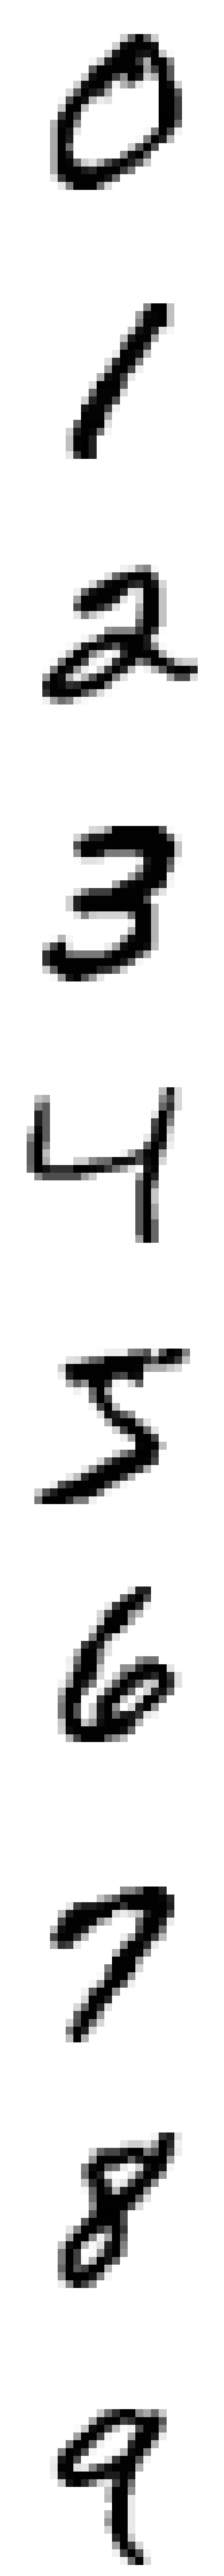

In [9]:
N = 10
plt.figure(figsize=(10, 10*N))
for i in range(1,N+1):
    plt.subplot(N,1,i)
    index_label_1 = next(j for j, (_, label) in enumerate(dataset) if label == i-1)
    x_1 = dataset[index_label_1]
    plt.imshow(x_1[0].squeeze(), cmap = 'binary')
    plt.axis('off')

In [10]:
autoencoder = train_ae(autoencoder, data)

KeyboardInterrupt: 

In [11]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], marker='.', c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break


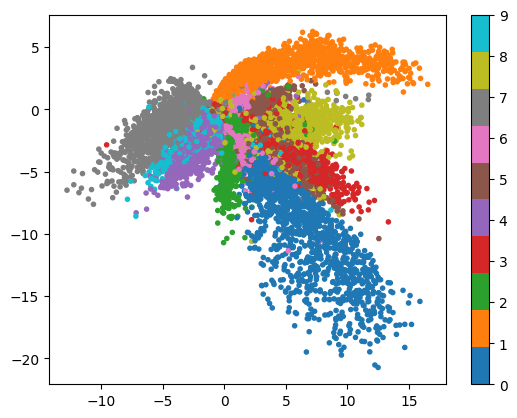

In [ ]:
plot_latent(autoencoder.to('cpu'), data)


In [12]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(i)*w:(i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])


NameError: name 'plt' is not defined

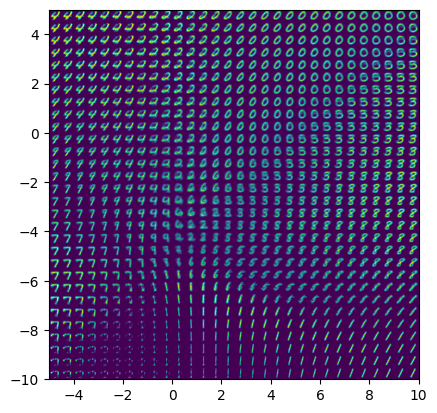

In [ ]:
plot_reconstructed(autoencoder, n=30)


### Cette fois un Variational AutoEncoder

In [13]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc # hack to get sampling on the GPU
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = ((sigma**2 + mu**2)/2 - torch.log(sigma) - 1/2).sum()
        return z


In [14]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [15]:
def train(autoencoder, data, alpha=1, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    loss_for_plot = np.zeros(epochs)
    loss_kl_for_plot = np.zeros(epochs)
    loss_recons_for_plot = np.zeros(epochs)
    for epoch in range(epochs):
        for x, y in data:
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss_recons = ((x - x_hat)**2).sum() 
            loss_kl = autoencoder.encoder.kl
            loss = loss_recons + alpha*loss_kl
            loss.backward()
            opt.step()
        # Pour les affichages : 
        loss_for_plot[epoch] = loss
        loss_kl_for_plot[epoch] = loss_kl
        loss_recons_for_plot[epoch] = loss_recons
        print('epoch n° : '+str(epoch))
        print('loss recons : '+str(int(loss_recons)))
        print('loss KL : '+str(int(loss_kl)))
        print('loss tot : '+ str(int(loss)))
        print('-------------------------------------------')
    plt.plot(np.arange(epochs), loss_for_plot, label='erreur totale = recostruction + alpha*kl')
    plt.plot(np.arange(epochs), loss_kl_for_plot, label = 'kl')
    plt.plot(np.arange(epochs), loss_recons_for_plot, label='erreur de reconstruction')
    plt.legend()
    plt.show()
    return autoencoder



epoch n° : 0
loss recons : 3906
loss KL : 307
loss tot : 4214
-------------------------------------------
epoch n° : 1
loss recons : 3402
loss KL : 370
loss tot : 3772
-------------------------------------------
epoch n° : 2
loss recons : 3587
loss KL : 357
loss tot : 3945
-------------------------------------------
epoch n° : 3
loss recons : 3633
loss KL : 349
loss tot : 3982
-------------------------------------------
epoch n° : 4
loss recons : 3681
loss KL : 375
loss tot : 4056
-------------------------------------------
epoch n° : 5
loss recons : 3563
loss KL : 357
loss tot : 3920
-------------------------------------------
epoch n° : 6
loss recons : 3321
loss KL : 416
loss tot : 3738
-------------------------------------------
epoch n° : 7
loss recons : 3512
loss KL : 397
loss tot : 3909
-------------------------------------------
epoch n° : 8
loss recons : 3465
loss KL : 392
loss tot : 3858
-------------------------------------------
epoch n° : 9
loss recons : 3169
loss KL : 401


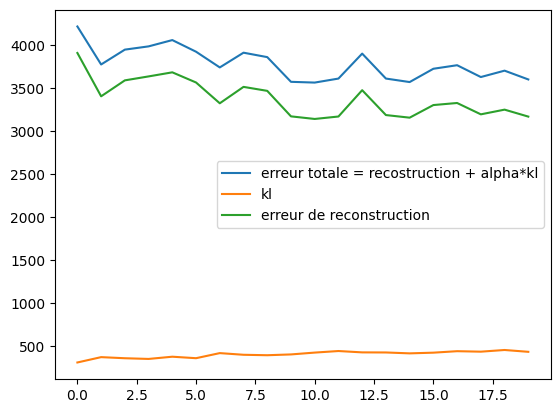

In [16]:
vae = VariationalAutoencoder(latent_dims)  #GPU
vae = train(vae, data)


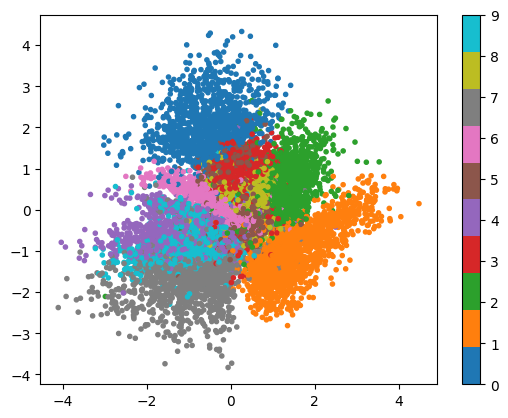

In [17]:

plot_latent(vae, data)


epoch n° : 0
loss recons : 3908
loss KL : 2256
loss tot : 3908
-------------------------------------------
epoch n° : 1
loss recons : 3334
loss KL : 2151
loss tot : 3334
-------------------------------------------
epoch n° : 2
loss recons : 3207
loss KL : 2330
loss tot : 3207
-------------------------------------------
epoch n° : 3
loss recons : 3087
loss KL : 2509
loss tot : 3087
-------------------------------------------
epoch n° : 4
loss recons : 3419
loss KL : 2387
loss tot : 3419
-------------------------------------------
epoch n° : 5
loss recons : 2935
loss KL : 3018
loss tot : 2935
-------------------------------------------
epoch n° : 6
loss recons : 3221
loss KL : 2788
loss tot : 3221
-------------------------------------------
epoch n° : 7
loss recons : 3023
loss KL : 2370
loss tot : 3023
-------------------------------------------
epoch n° : 8
loss recons : 3180
loss KL : 2872
loss tot : 3180
-------------------------------------------
epoch n° : 9
loss recons : 2976
loss 

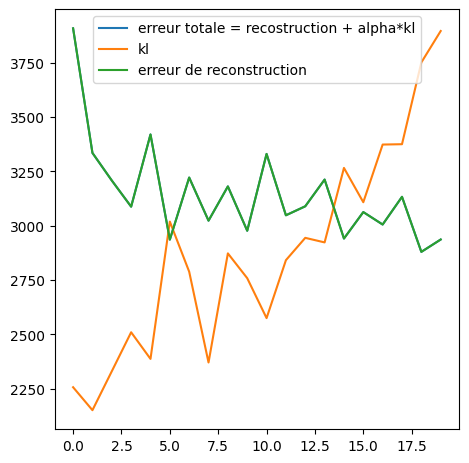

C:\Users\salvador\AppData\Local\Temp\ipykernel_13660\3395567649.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nb_row, nb_cols, i+1)


epoch n° : 0
loss recons : 3488
loss KL : 2330
loss tot : 3488
-------------------------------------------
epoch n° : 1
loss recons : 3396
loss KL : 2191
loss tot : 3396
-------------------------------------------
epoch n° : 2
loss recons : 3294
loss KL : 2742
loss tot : 3294
-------------------------------------------
epoch n° : 3
loss recons : 3114
loss KL : 3355
loss tot : 3114
-------------------------------------------
epoch n° : 4
loss recons : 3521
loss KL : 2893
loss tot : 3521
-------------------------------------------
epoch n° : 5
loss recons : 3167
loss KL : 2787
loss tot : 3167
-------------------------------------------
epoch n° : 6
loss recons : 3384
loss KL : 2665
loss tot : 3384
-------------------------------------------
epoch n° : 7
loss recons : 3057
loss KL : 2988
loss tot : 3057
-------------------------------------------
epoch n° : 8
loss recons : 3196
loss KL : 3888
loss tot : 3196
-------------------------------------------
epoch n° : 9
loss recons : 2945
loss 

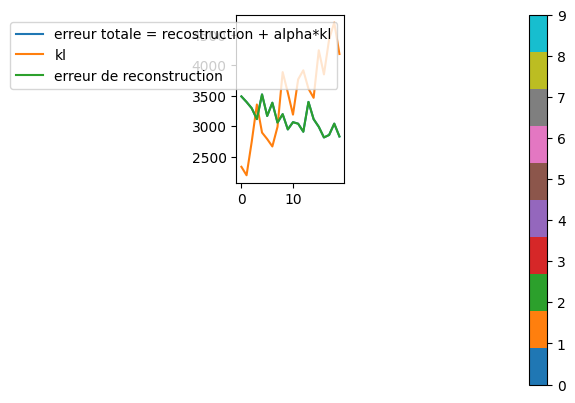

C:\Users\salvador\AppData\Local\Temp\ipykernel_13660\3395567649.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nb_row, nb_cols, i+2)


Text(0.5, 1.0, 'AutoEncoder')

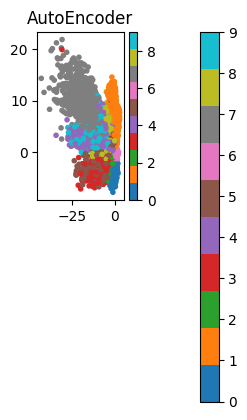

In [ ]:
list_alpha = [0, 0]
nb_cols = 4
nb_row = 2

plt.figure(figsize=(6*nb_cols, 6*nb_row))
for (i,a) in enumerate(list_alpha) : 
    plt.subplot(nb_row, nb_cols, i+1)
    vae_alpha = VariationalAutoencoder(latent_dims) # GPU
    vae_alpha  = train(vae_alpha, data, alpha=a)
    plot_latent(vae_alpha, data)
    plt.title('VAE, alpha = '+str(a))


plt.subplot(nb_row, nb_cols, i+2)
ae_comp = Autoencoder(latent_dims) # GPU
ae_comp = train_ae(ae_comp, data)
plot_latent(ae_comp, data)
plt.title('AutoEncoder')

KeyboardInterrupt: 

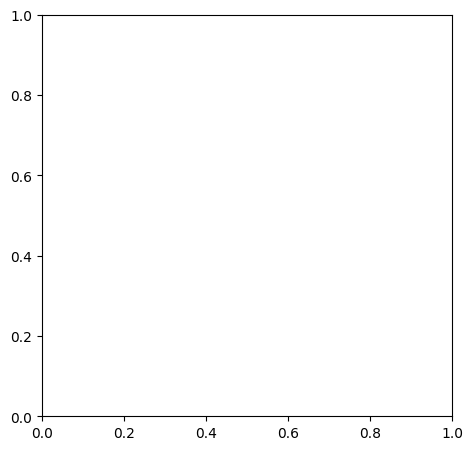

In [ ]:
#  /!\ on entraine autant de VAE que de valeurs d'alpha, ne ps executer la cellule sans réflechir 
# ici on plot les nuage de points dans l'esp latent
list_alpha = [0,  0.5, 1, 
             2,  5, 10]
nb_cols = 3
nb_row = 4

plt.figure(figsize=(6*nb_cols, 6*nb_row))
for (i,a) in enumerate(list_alpha) : 
    plt.subplot(nb_row, nb_cols, i+1)
    vae_alpha = VariationalAutoencoder(latent_dims) # GPU
    vae_alpha  = train(vae_alpha, data, alpha=a)
    plot_latent(vae_alpha, data)
    plt.title('alpha = '+str(a))


In [26]:
def plot_latent(autoencoder, data, num_batches=100, s = 1):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], marker='.',s=s, c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [66]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, x in enumerate(np.linspace(*r0, n)):
        for j, y in enumerate(np.linspace(*r1, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[i*w:(i+1)*w, (n-j-1)*w:(n-j)*w] = np.transpose(x_hat)
    plt.imshow(np.transpose(img), extent=[*r0, *r1])

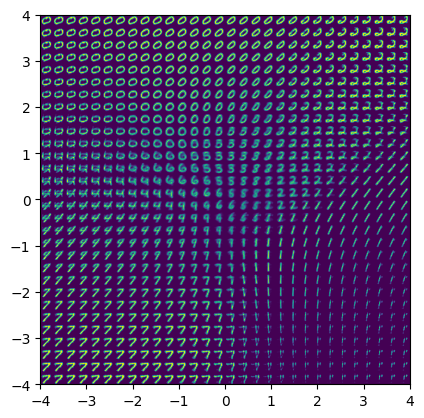

In [68]:
plot_reconstructed(vae, r0=(-4, 4), r1=(-4, 4), n=30)


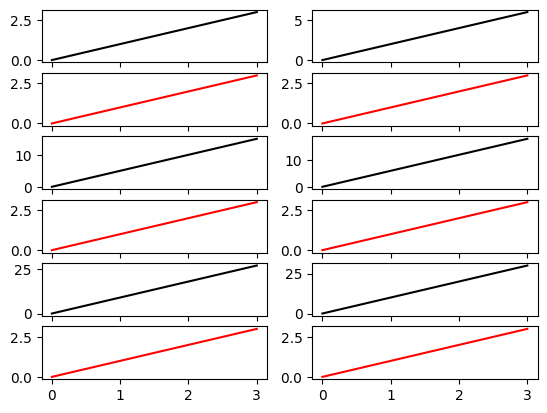

In [ ]:
xx = [0,1,2,3]
yy = np.array([0,1,2,3])
row = 3
col = 2
j=1
for _ in range(1,row*col+1):
    plt.subplot(row*2, col, j)
    plt.plot(xx, j*yy, color='k')
    plt.subplot(row*2, col, j+col)
    plt.plot(xx, yy, color='r')
    if j%col>0:
        j+=1
    else :
        j+=col+1

epoch n° : 0
loss recons : 3769
loss KL : 2091
loss tot : 3769
-------------------------------------------
epoch n° : 1
loss recons : 3156
loss KL : 2562
loss tot : 3156
-------------------------------------------
epoch n° : 2
loss recons : 3571
loss KL : 2386
loss tot : 3571
-------------------------------------------
epoch n° : 3
loss recons : 3270
loss KL : 2809
loss tot : 3270
-------------------------------------------
epoch n° : 4
loss recons : 3299
loss KL : 2861
loss tot : 3299
-------------------------------------------
epoch n° : 5
loss recons : 3629
loss KL : 2204
loss tot : 3629
-------------------------------------------
epoch n° : 6
loss recons : 3513
loss KL : 2535
loss tot : 3513
-------------------------------------------
epoch n° : 7
loss recons : 3102
loss KL : 3127
loss tot : 3102
-------------------------------------------
epoch n° : 8
loss recons : 3013
loss KL : 3168
loss tot : 3013
-------------------------------------------
epoch n° : 9
loss recons : 2898
loss 

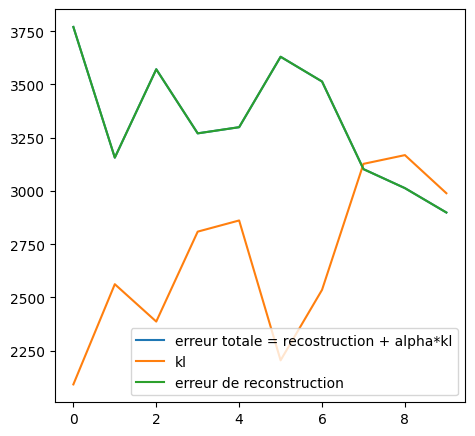

C:\Users\salvador\AppData\Local\Temp\ipykernel_13660\3104019220.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nb_row, nb_cols, i+nb_cols)


epoch n° : 0
loss recons : 3638
loss KL : 409
loss tot : 3842
-------------------------------------------
epoch n° : 1
loss recons : 3702
loss KL : 457
loss tot : 3931
-------------------------------------------
epoch n° : 2
loss recons : 3283
loss KL : 474
loss tot : 3521
-------------------------------------------
epoch n° : 3
loss recons : 3133
loss KL : 481
loss tot : 3374
-------------------------------------------
epoch n° : 4
loss recons : 3592
loss KL : 459
loss tot : 3822
-------------------------------------------
epoch n° : 5
loss recons : 3577
loss KL : 464
loss tot : 3809
-------------------------------------------
epoch n° : 6
loss recons : 3176
loss KL : 485
loss tot : 3419
-------------------------------------------
epoch n° : 7
loss recons : 3072
loss KL : 511
loss tot : 3328
-------------------------------------------
epoch n° : 8
loss recons : 3011
loss KL : 501
loss tot : 3261
-------------------------------------------
epoch n° : 9
loss recons : 3065
loss KL : 504


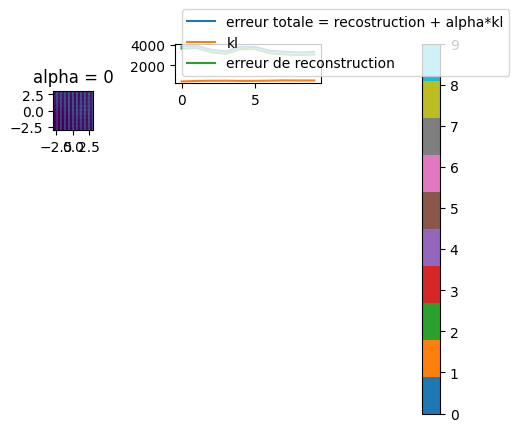

C:\Users\salvador\AppData\Local\Temp\ipykernel_13660\3104019220.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nb_row, nb_cols, i)


epoch n° : 0
loss recons : 3879
loss KL : 306
loss tot : 4186
-------------------------------------------
epoch n° : 1
loss recons : 3692
loss KL : 349
loss tot : 4041
-------------------------------------------
epoch n° : 2
loss recons : 3538
loss KL : 350
loss tot : 3888
-------------------------------------------
epoch n° : 3
loss recons : 3616
loss KL : 372
loss tot : 3988
-------------------------------------------
epoch n° : 4
loss recons : 3561
loss KL : 383
loss tot : 3944
-------------------------------------------
epoch n° : 5
loss recons : 3242
loss KL : 414
loss tot : 3656
-------------------------------------------
epoch n° : 6
loss recons : 3232
loss KL : 401
loss tot : 3634
-------------------------------------------
epoch n° : 7
loss recons : 3308
loss KL : 420
loss tot : 3729
-------------------------------------------
epoch n° : 8
loss recons : 3244
loss KL : 430
loss tot : 3674
-------------------------------------------
epoch n° : 9
loss recons : 3195
loss KL : 427


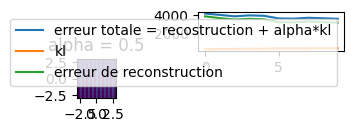

epoch n° : 0
loss recons : 4126
loss KL : 220
loss tot : 4566
-------------------------------------------
epoch n° : 1
loss recons : 3680
loss KL : 256
loss tot : 4192
-------------------------------------------
epoch n° : 2
loss recons : 3761
loss KL : 247
loss tot : 4256
-------------------------------------------
epoch n° : 3
loss recons : 3707
loss KL : 282
loss tot : 4271
-------------------------------------------
epoch n° : 4
loss recons : 3744
loss KL : 262
loss tot : 4269
-------------------------------------------
epoch n° : 5
loss recons : 3534
loss KL : 302
loss tot : 4138
-------------------------------------------
epoch n° : 6
loss recons : 3632
loss KL : 315
loss tot : 4263
-------------------------------------------
epoch n° : 7
loss recons : 3759
loss KL : 305
loss tot : 4370
-------------------------------------------
epoch n° : 8
loss recons : 3207
loss KL : 333
loss tot : 3873
-------------------------------------------
epoch n° : 9
loss recons : 3643
loss KL : 326


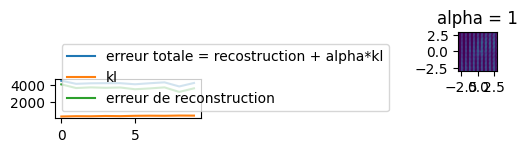

epoch n° : 0
loss recons : 4104
loss KL : 101
loss tot : 4611
-------------------------------------------
epoch n° : 1
loss recons : 4508
loss KL : 90
loss tot : 4960
-------------------------------------------
epoch n° : 2
loss recons : 4339
loss KL : 104
loss tot : 4860
-------------------------------------------
epoch n° : 3
loss recons : 3962
loss KL : 125
loss tot : 4587
-------------------------------------------
epoch n° : 4
loss recons : 4247
loss KL : 123
loss tot : 4865
-------------------------------------------
epoch n° : 5
loss recons : 4089
loss KL : 126
loss tot : 4720
-------------------------------------------
epoch n° : 6
loss recons : 4239
loss KL : 121
loss tot : 4847
-------------------------------------------
epoch n° : 7
loss recons : 4026
loss KL : 142
loss tot : 4736
-------------------------------------------
epoch n° : 8
loss recons : 4180
loss KL : 114
loss tot : 4755
-------------------------------------------
epoch n° : 9
loss recons : 4253
loss KL : 122
l

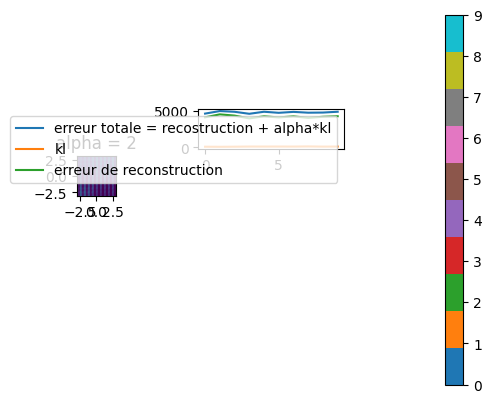

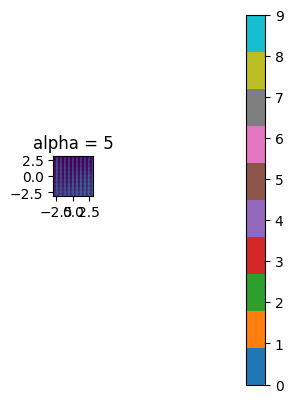

In [ ]:
#/!\ on entraine autant de VAE que de valeurs d'alpha, ne ps executer la cellule sans réflechir
#ici on plot les reconstruction de la carte de l'esp latent
list_alpha = [0, 0.5, 1,
              2, 5]
nb_cols = 3
nb_row = 4*2

plt.figure(figsize=(6*nb_cols, 6*nb_row))
i=1
for a in list_alpha : 
    plt.subplot(nb_row, nb_cols, i)
    vae_alpha = VariationalAutoencoder(latent_dims) # GPU
    vae_alpha  = train(vae_alpha, data, alpha=a, epochs = 10)

    plot_latent(vae_alpha, data)
    plt.subplot(nb_row, nb_cols, i+nb_cols)
    plot_reconstructed(vae_alpha,r0=(-3, 3), r1=(-3, 3), n=30)
    plt.title('alpha = '+str(a))
    
    if i%nb_cols>0:
        i+=1
    else :
        i+=nb_cols+1

### Interpolation entre deux points de l'espace latent

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
# Charger le jeu de données MNIST hors du DataLoader
mnist_dataset = torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True)


lab_1 = 1
lab_2 = 0
# Trouver un exemple avec l'étiquette 1
index_label_1 = next(i for i, (_, label) in enumerate(mnist_dataset) if label == lab_1)
x_1 = mnist_dataset[index_label_1]

# Trouver un exemple avec l'étiquette 0
index_label_0 = next(i for i, (_, label) in enumerate(mnist_dataset) if label == lab_2)
x_2 = mnist_dataset[index_label_0]

# Accéder aux données et aux étiquettes
data_x_1, label_x_1 = x_1
data_x_2, label_x_2 = x_2

# Afficher les informations
print(f"Pour x_1 (étiquette 1) :")
print(f" - Données : {data_x_1.shape}")
print(f" - Étiquette : {label_x_1}")

print("\n")

print(f"Pour x_2 (étiquette 0) :")
print(f" - Données : {data_x_2.shape}")
print(f" - Étiquette : {label_x_2}")


Pour x_1 (étiquette 1) :
 - Données : torch.Size([1, 28, 28])
 - Étiquette : 1


Pour x_2 (étiquette 0) :
 - Données : torch.Size([1, 28, 28])
 - Étiquette : 0


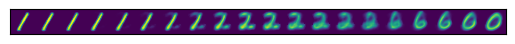

In [ ]:
interpolate(vae, data_x_1, data_x_2, n=20)


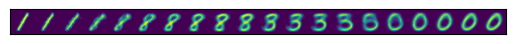

In [ ]:
interpolate(autoencoder, data_x_1, data_x_2, n=20)
